In [1]:
import sys
sys.path.append('/home/hashmi/ResearchBook/Tracking/Notebooks/Moore')
from central_import import *

figure_directory = '../../../Figures/LinearModel/'
os.makedirs(figure_directory,exist_ok=True)
set_plot_style()

In [2]:
data = pd.read_parquet('../DataBuild/DownstreamTrackTrainingData.parquet')

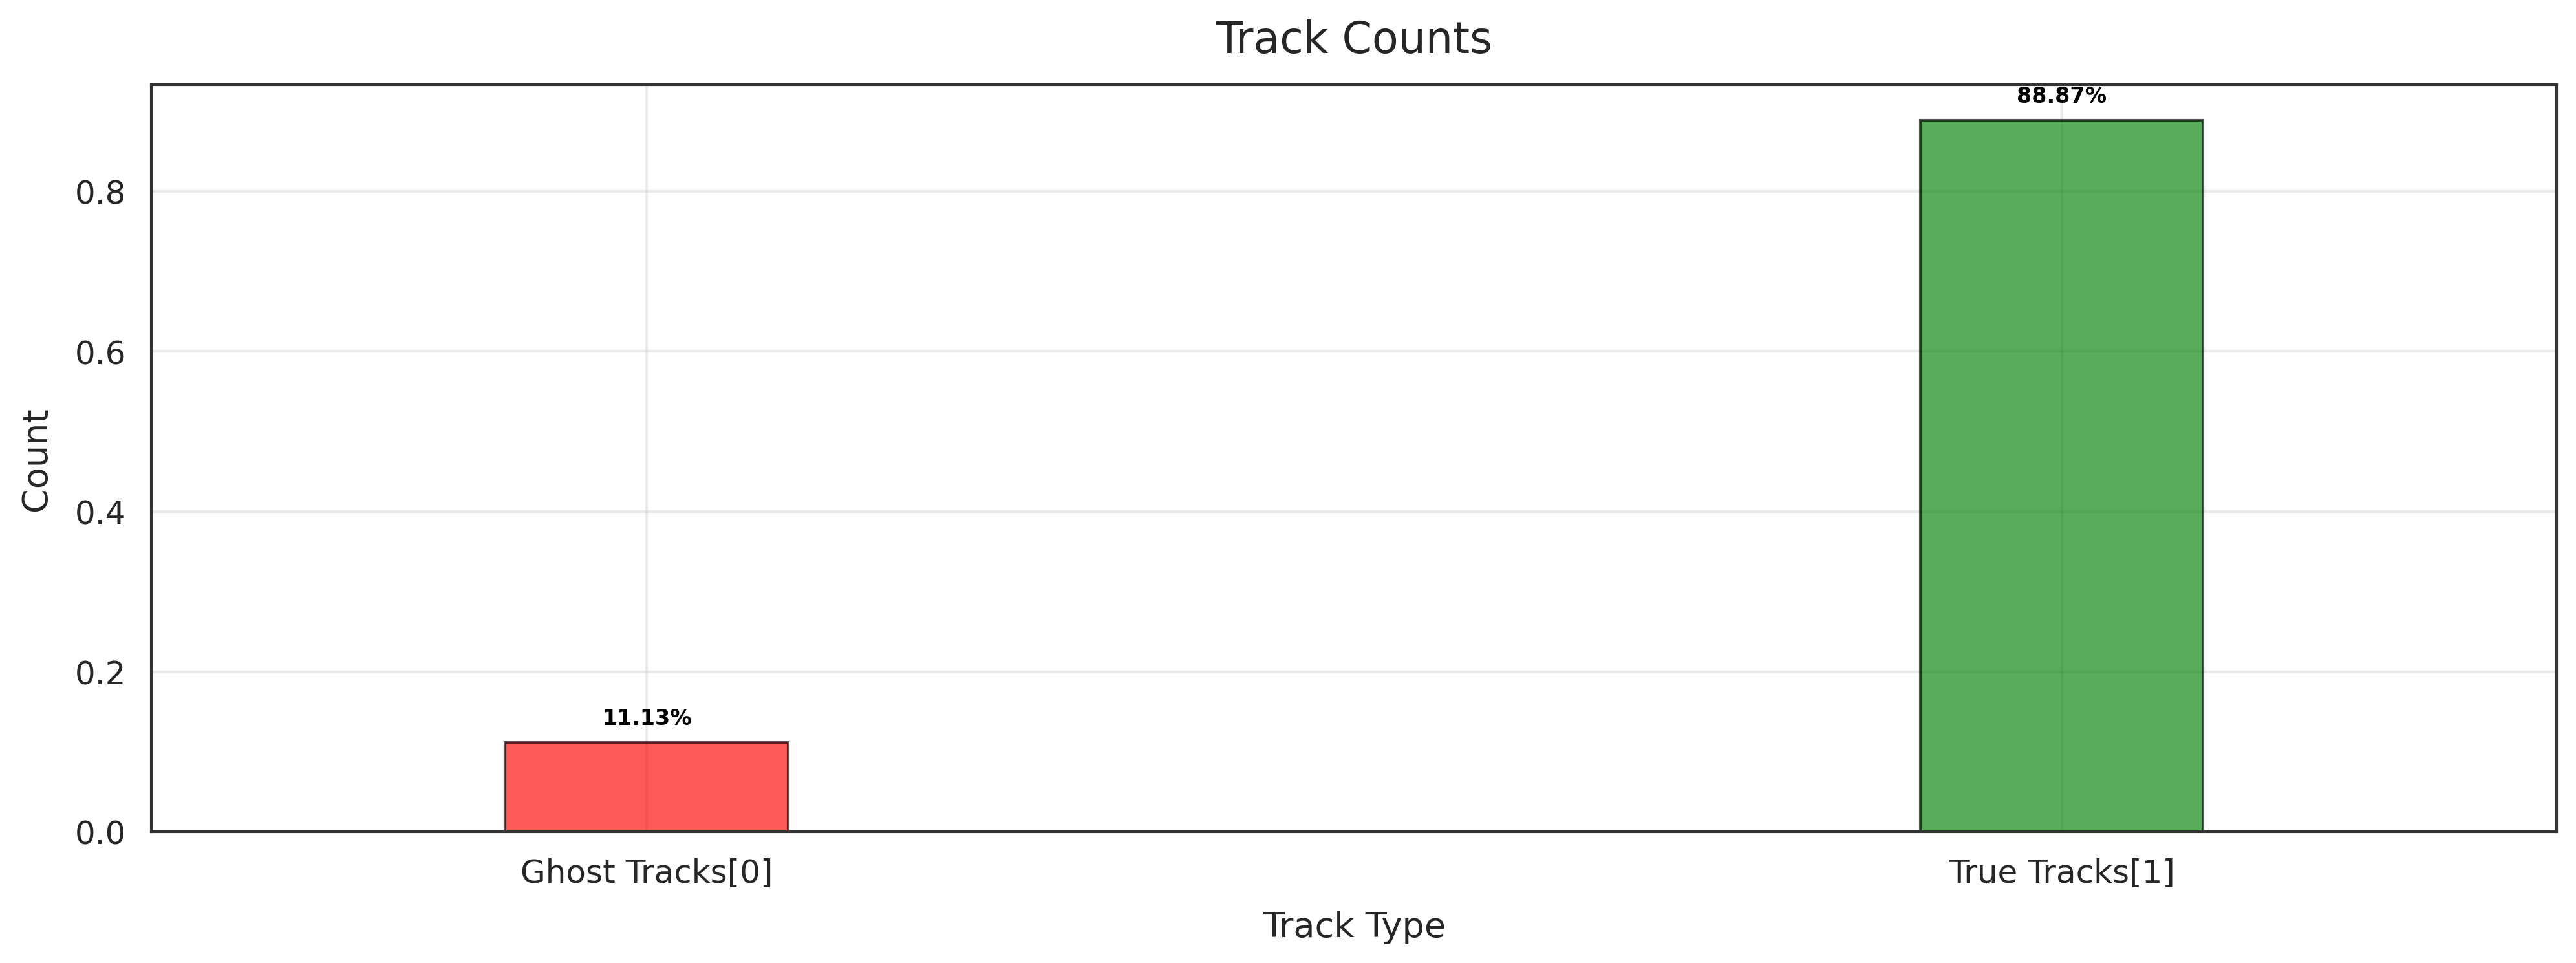

In [3]:
# Plot : Imbalance in Data
ax =data['isMatched'].map({True:"True Tracks[1]",False:"Ghost Tracks[0]"}).value_counts(ascending=True,normalize=True).plot(
    kind='bar',color=['red','green'],alpha=0.65,figsize=(16,5),title='Track Counts',xlabel='Track Type', ylabel='Count',rot=0,width=0.2,edgecolor='black')


for p in ax.patches:
    ax.annotate(f'{round(p.get_height() * 100,2) }%',  # Label the height (Y-value)
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the label at the top of the bar
                xytext=(0, 5),  # Offset the label a bit above the bar
                textcoords='offset points',
                ha='center', va='bottom',  # Horizontally and vertically align the text
                color='black', fontsize=8, fontweight='bold')
  
plt.savefig(f"{figure_directory}/Downstream_ClassDistribution.png")

plt.show()

In [4]:
data.head()

,p,pt,tx,ty,ovtx_x,ovtx_y,eta,phi,nUTHits,chi2perdof,isMatched
0,5909.817556,428.277705,-0.069300,0.021840,-154.245087,51.721882,3.316430,2.836300,4,0.294202,True
1,5538.734420,282.645307,-0.042253,0.028734,-89.850204,68.142715,3.667824,2.544377,4,0.115257,True
2,11578.541378,630.442231,-0.054486,0.002202,-123.821136,4.228925,3.602892,3.101207,4,0.193786,True
3,15305.070720,833.397923,-0.043621,0.032728,-97.630684,76.527649,3.602833,2.497917,4,0.197270,True
4,7032.182276,123.075688,-0.009546,0.014672,-14.400462,33.429001,4.738523,2.147612,4,0.218492,True


In [5]:
x=data.drop(['isMatched'],axis=1)
y=data['isMatched']

columns=np.array(['P','Pt','Tx','Ty', 'X','Y','Eta','Phi','nUTHits','Chi2PerDoF'])
x.columns=columns


In [6]:
#Train-Test-Evaluation Split
x_train,x_temp,y_train,y_temp=train_test_split(x,y,stratify=y,random_state=51)
x_test,x_eval,y_test,y_eval=train_test_split(x_temp,y_temp,stratify=y_temp,random_state=51)

#Preprocessing of Train-Test Data
x_train=pd.DataFrame(scaler.fit_transform(x_train),columns=x.columns)
x_test=pd.DataFrame(scaler.transform(x_test),columns=x.columns)
x_eval=pd.DataFrame(scaler.transform(x_eval),columns=x.columns)
x_train,y_train=sampler.fit_resample(x_train,y_train)
x_eval,y_eval=sampler.fit_resample(x_eval,y_eval)

In [7]:
#Logit Model building and Evaluation
model = LogisticRegression()
model.fit(x_train,y_train)

y_predict = model.predict(x_test)

print("ROC-Score:", round(roc_auc_score(y_test,y_predict)*100,2),"%")
print("F1-Score:", round(f1_score(y_test,y_predict)*100,2),"%")

ROC-Score: 66.69 %
F1-Score: 78.95 %


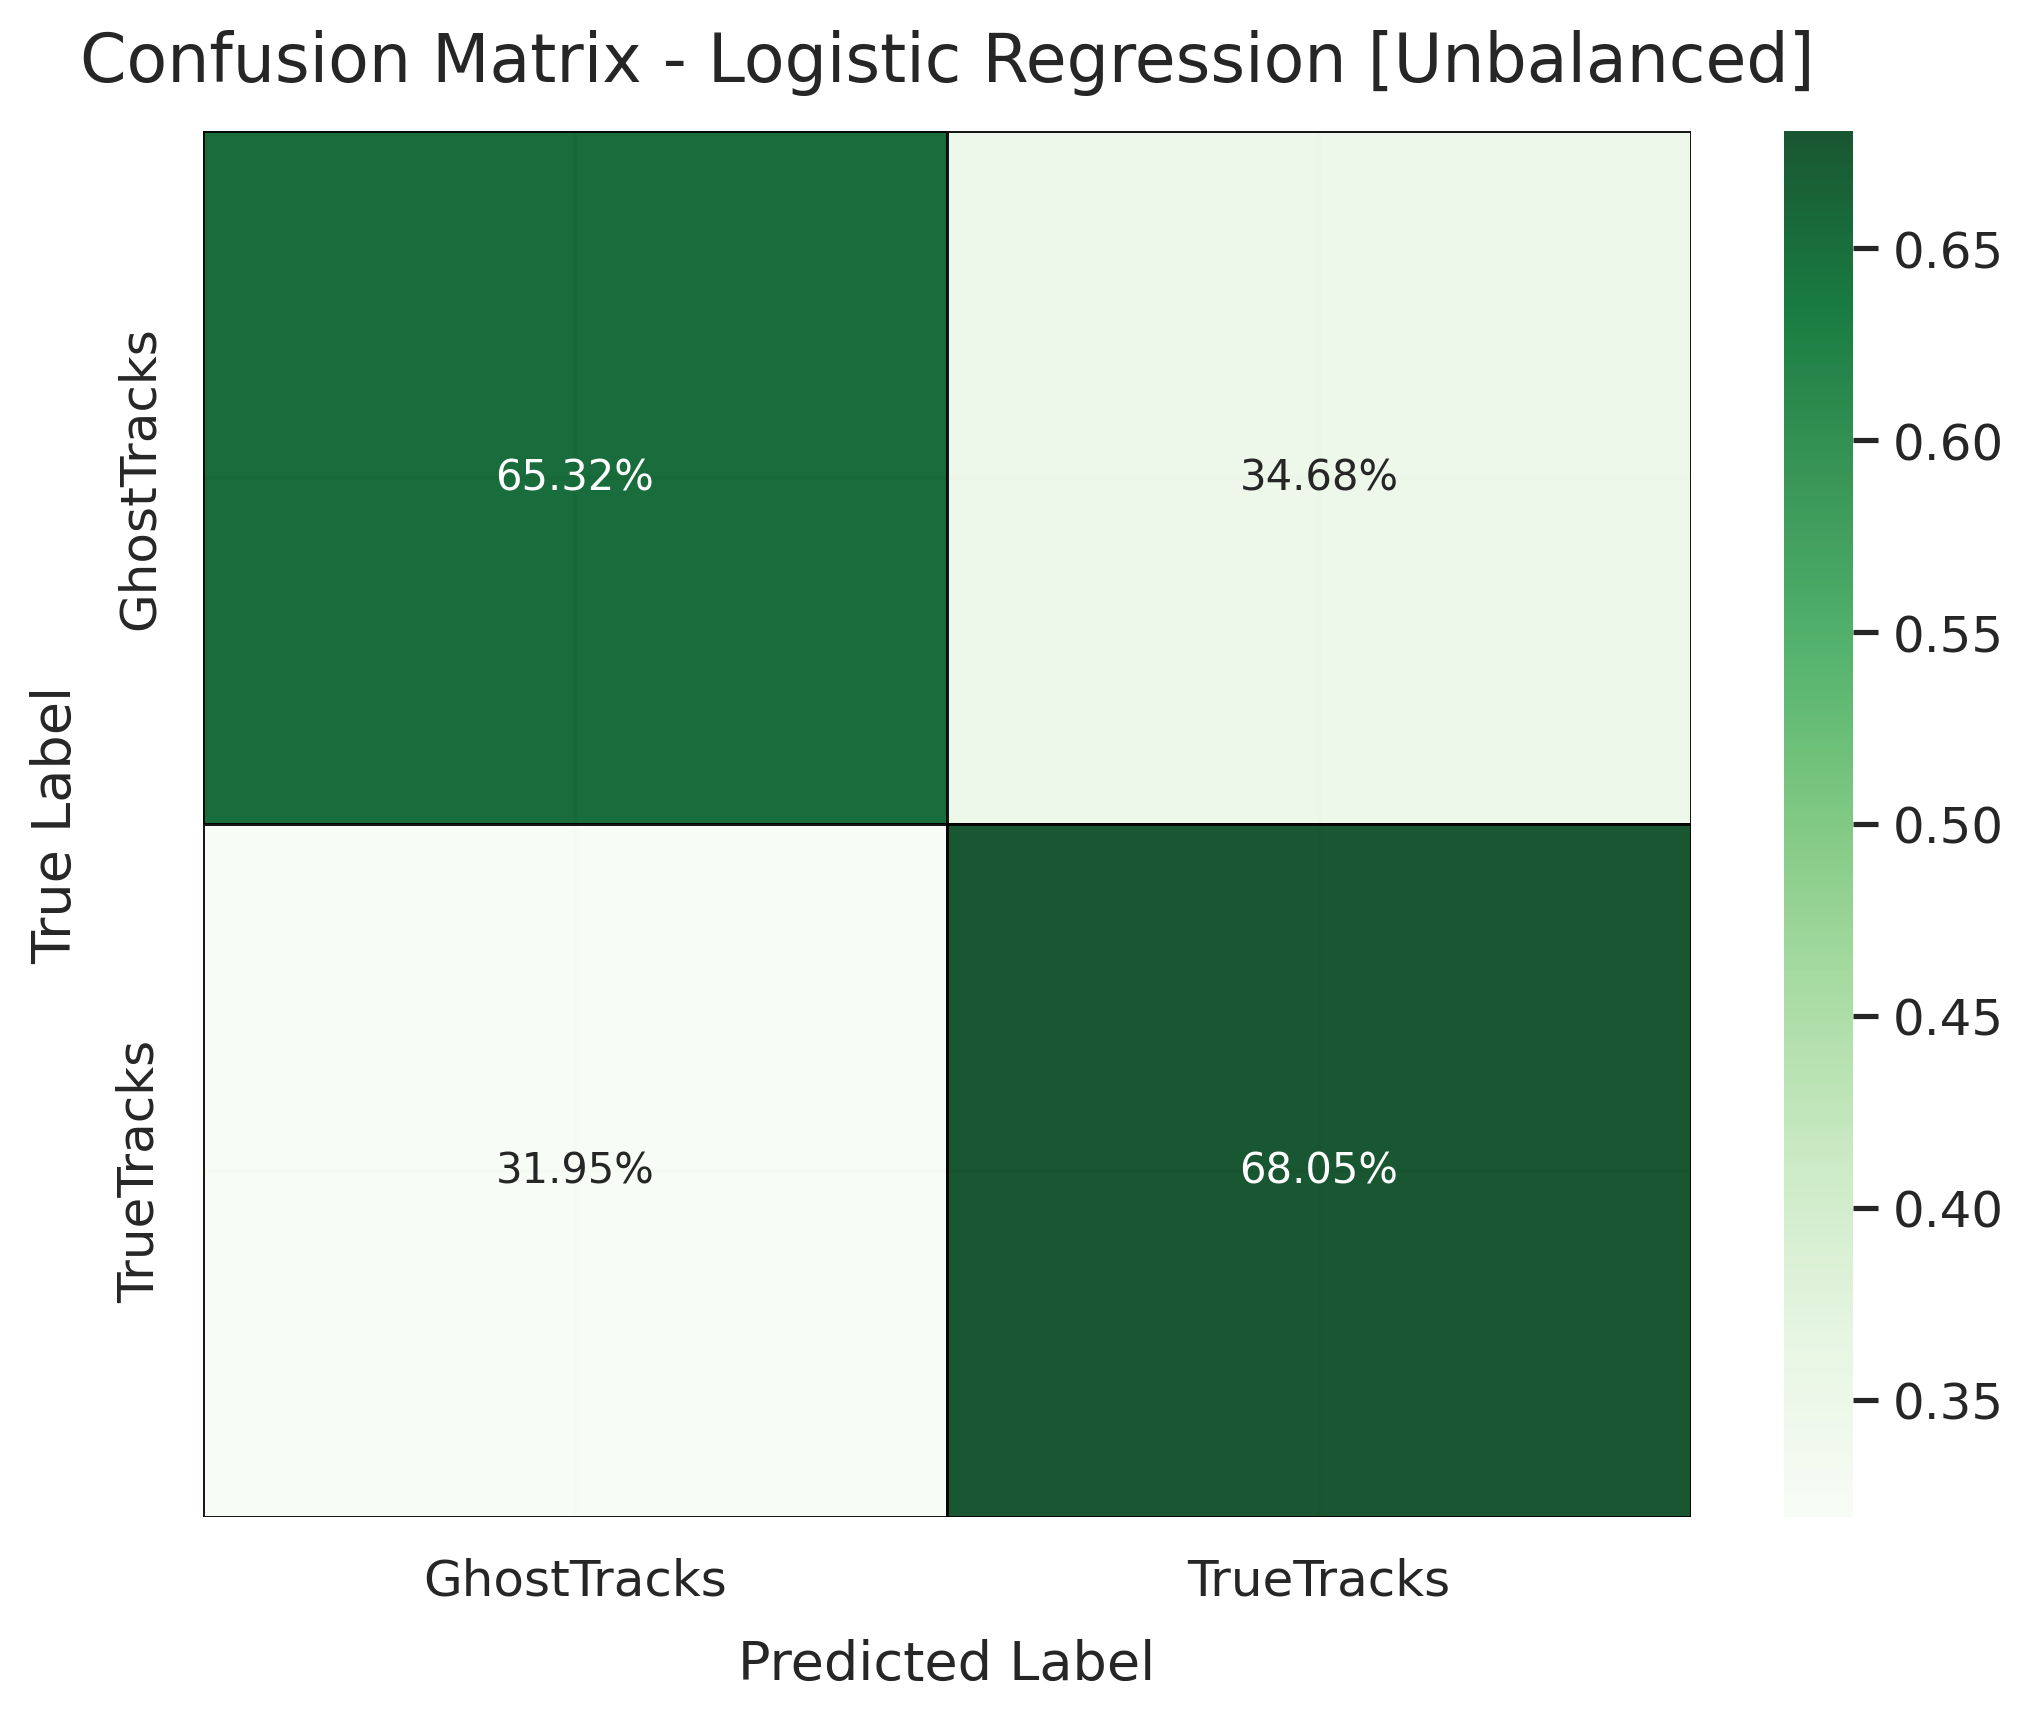

In [8]:
# ConfusionMatrix Test [Unbalanced]
y_predict = model.predict(x_test)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_predict,normalize='true'), xticklabels=['GhostTracks', 'TrueTracks'],yticklabels=['GhostTracks', 'TrueTracks'], fmt='.2%',annot=True, annot_kws={'fontsize': 10}, 
            cmap='Greens',linewidths=0.7,linecolor='black',alpha=0.9)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression [Unbalanced]')
plt.savefig(f"{figure_directory}/Downstream_Logit_CM_Unbalanced.png")
plt.show()


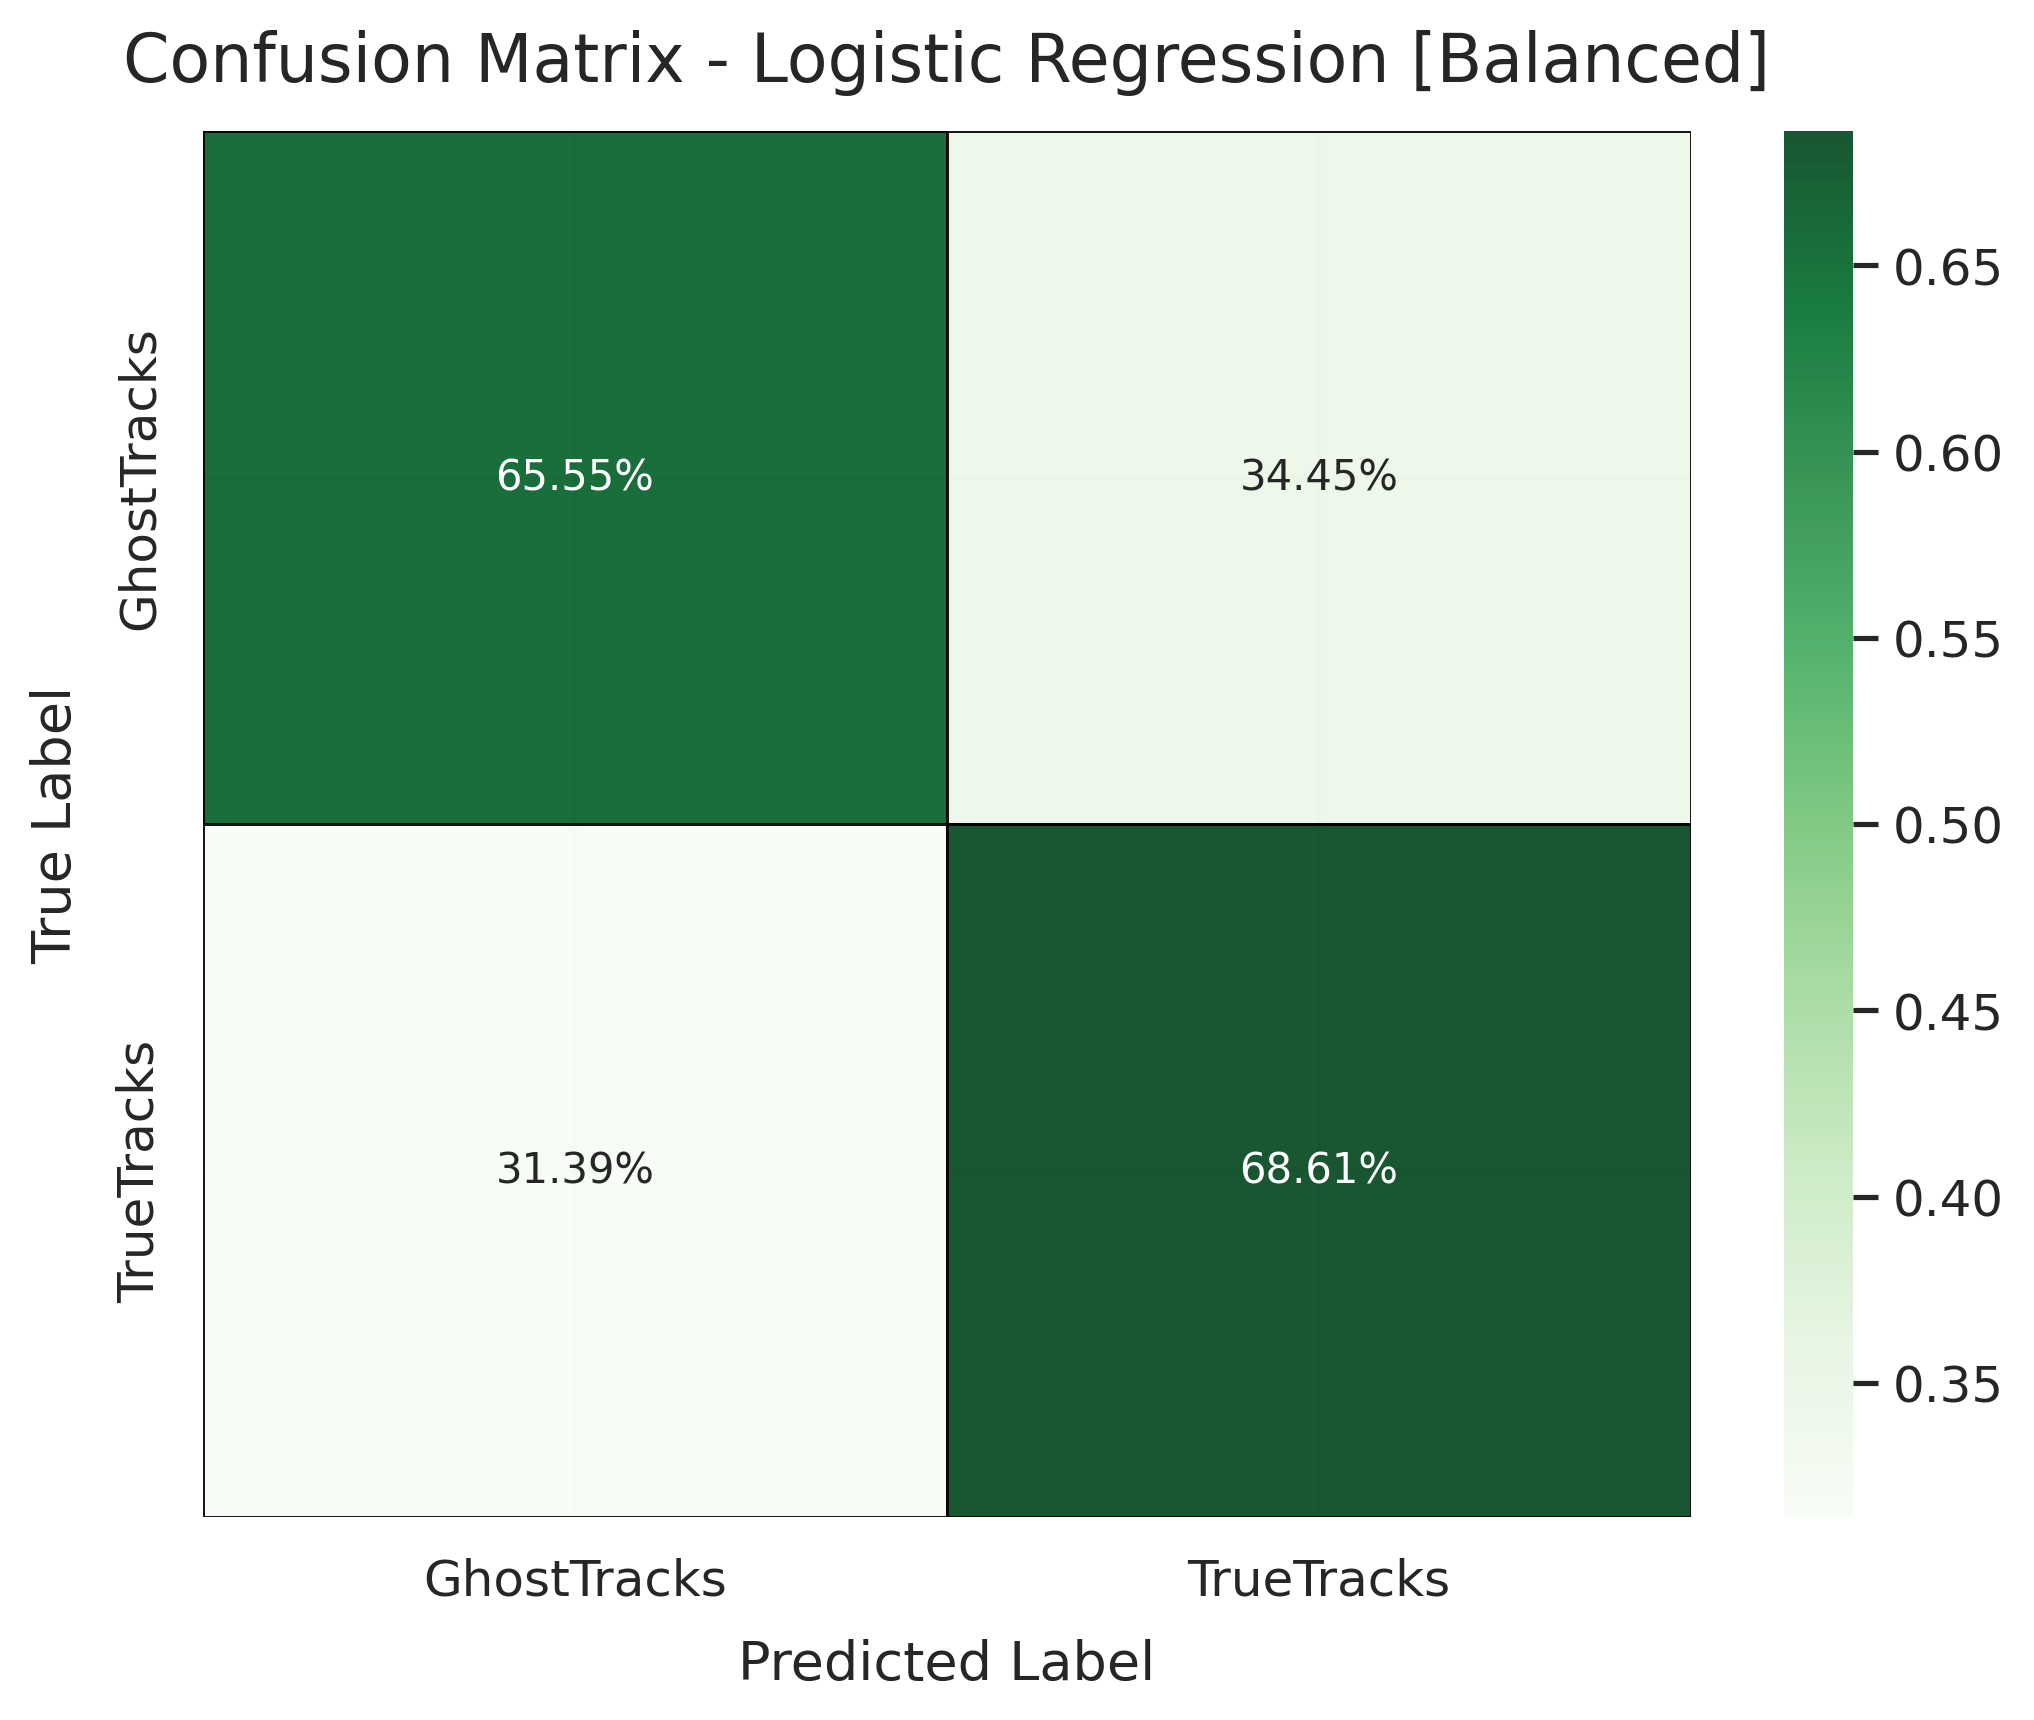

In [9]:
# ConfusionMatrix Eval [Balanced]
y_predict = model.predict(x_eval)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_eval, y_predict,normalize='true'), xticklabels=['GhostTracks', 'TrueTracks'],yticklabels=['GhostTracks', 'TrueTracks'], fmt='.2%',annot=True, annot_kws={'fontsize': 10}, 
            cmap='Greens',linewidths=0.7,linecolor='black',alpha=0.9)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression [Balanced]')
plt.savefig(f"{figure_directory}/Downstream_Logit_CM_Balanced.png")
plt.show()


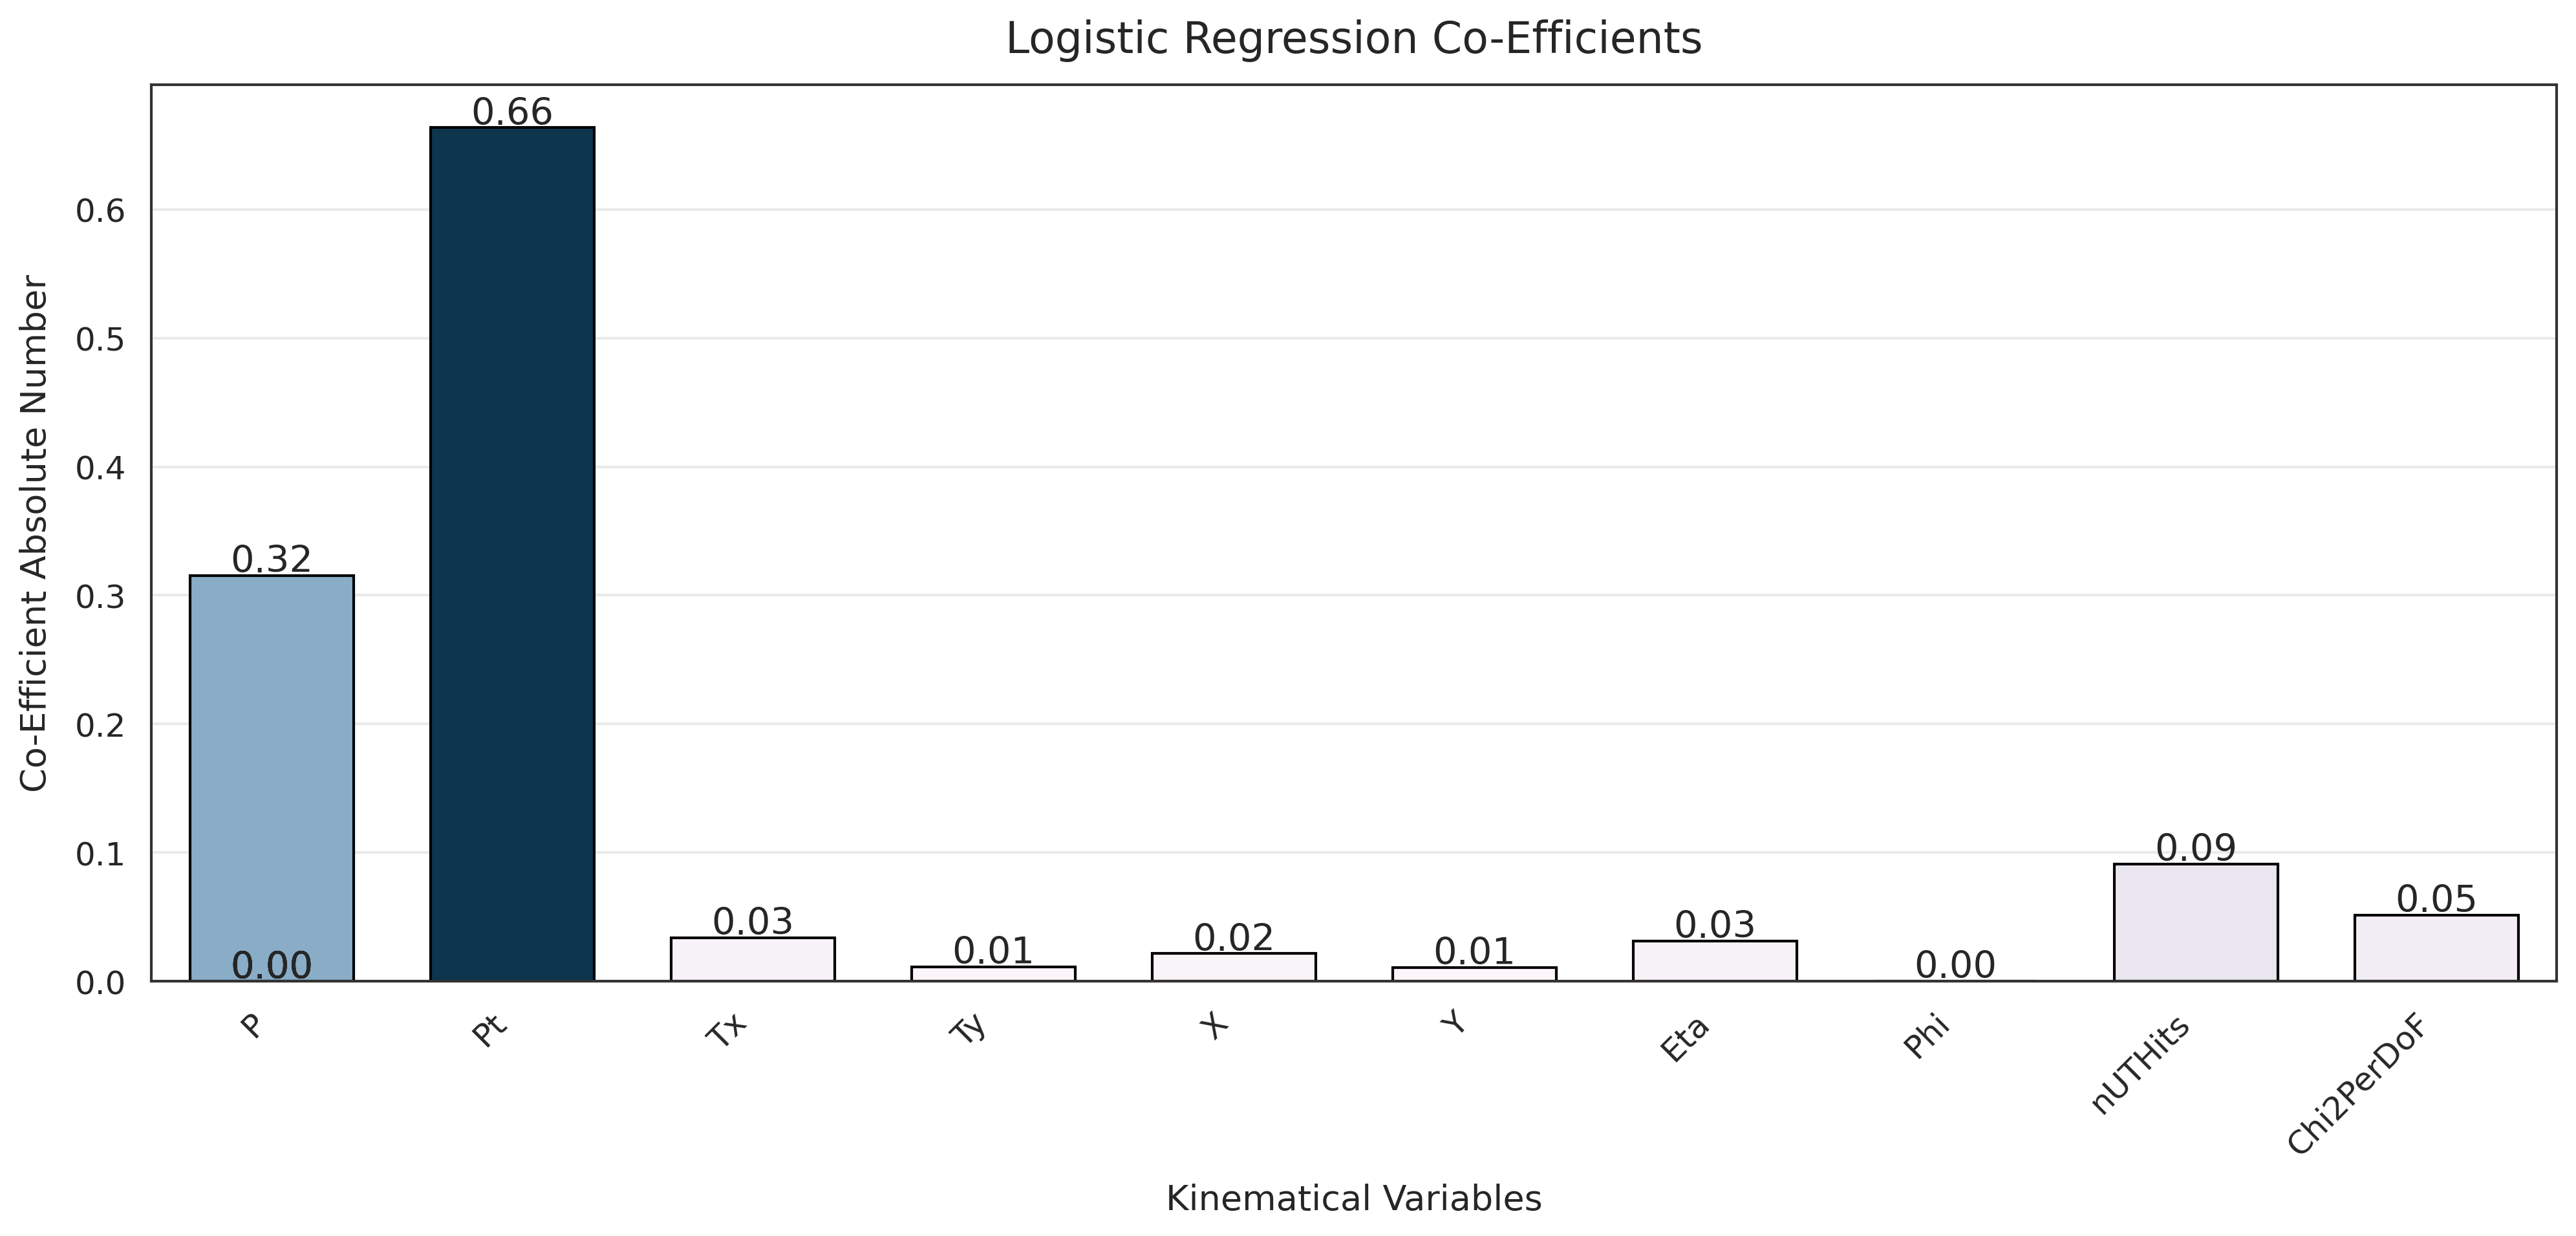

In [10]:
# Co-Efficients Absolute Values - Importance
plt.figure(figsize=(16, 6))
featureImportance = np.abs(model.coef_ [0]/ np.sum(model.coef_[0]))

ax=sns.barplot(x=columns, y=featureImportance,hue=np.abs(model.coef_[0]),edgecolor='black',palette='PuBu',gap=0.15)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points')
plt.title('Logistic Regression Co-Efficients')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Kinematical Variables')
plt.ylabel('Co-Efficient Absolute Number')
ax.legend_.remove()
plt.savefig(f"{figure_directory}/Downstream_Logit_FI.png")
plt.show()

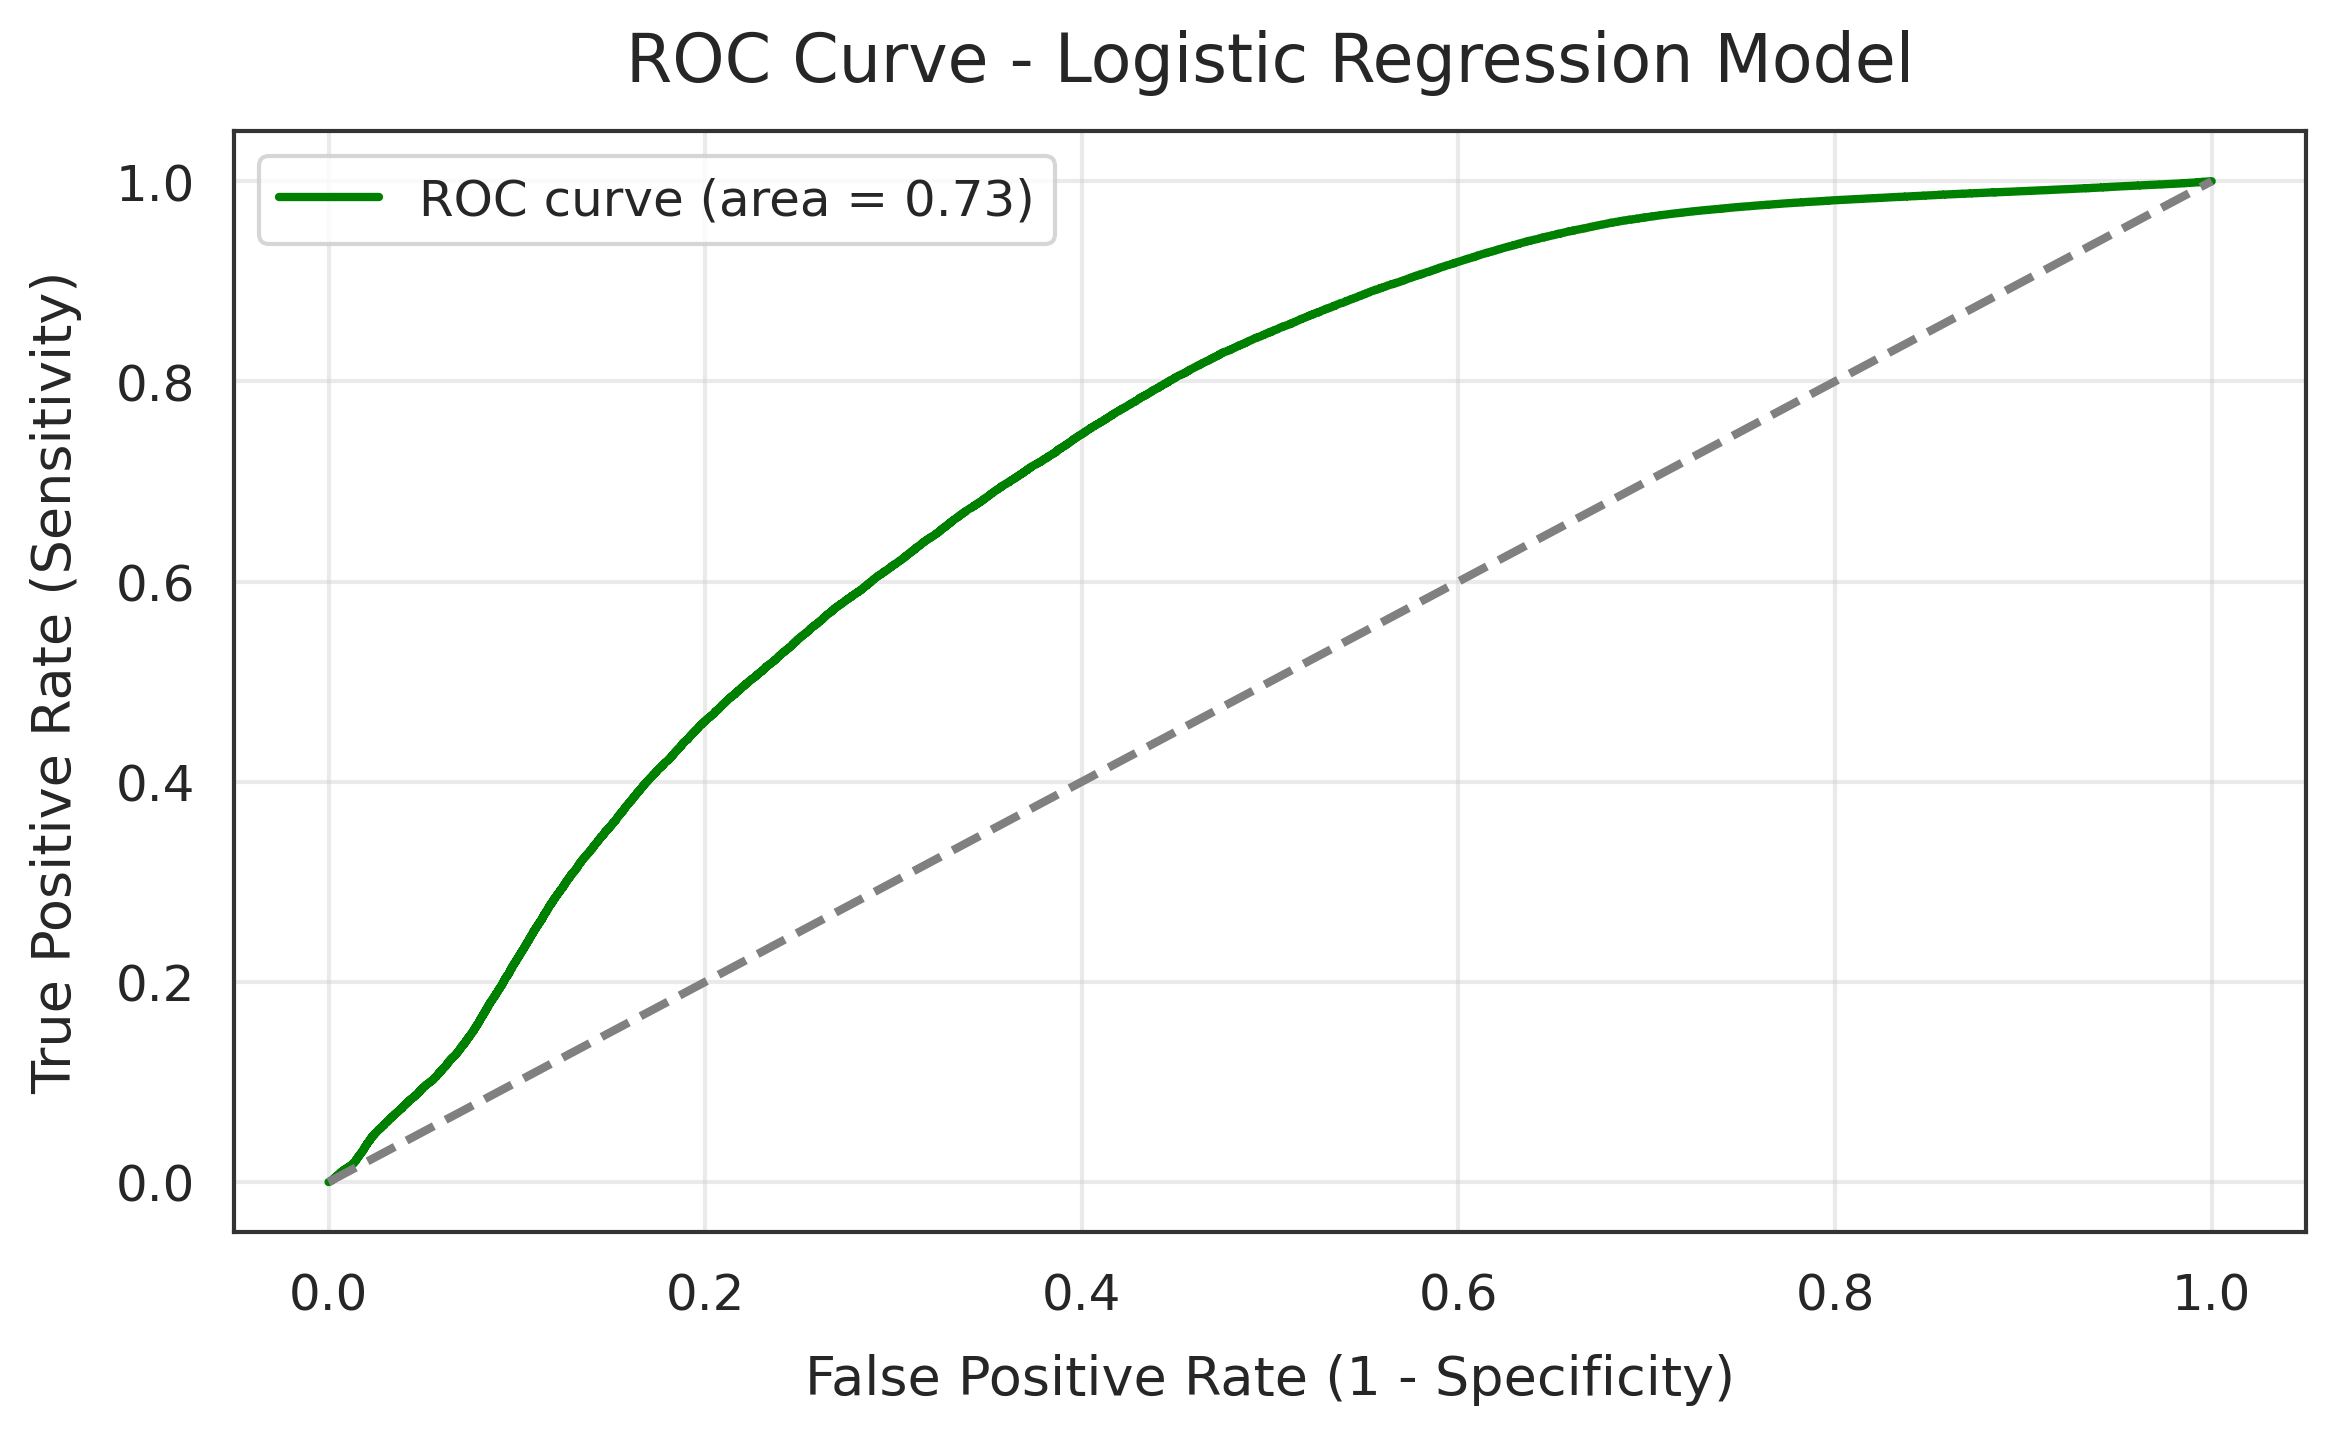

In [11]:
evaluation=x_test.copy()

probabilityValue = model.predict_proba(evaluation)[:,1] #First Probability will make the plot upside down
fpr, tpr, threshold =roc_curve(y_test,  probabilityValue)

plt.figure(figsize=(8, 5))
plt.title('ROC Curve - Logistic Regression Model')
plt.plot(fpr, tpr,color='Green',label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig(f"{figure_directory}/Downstream_Logit_ROC.png")
plt.show()

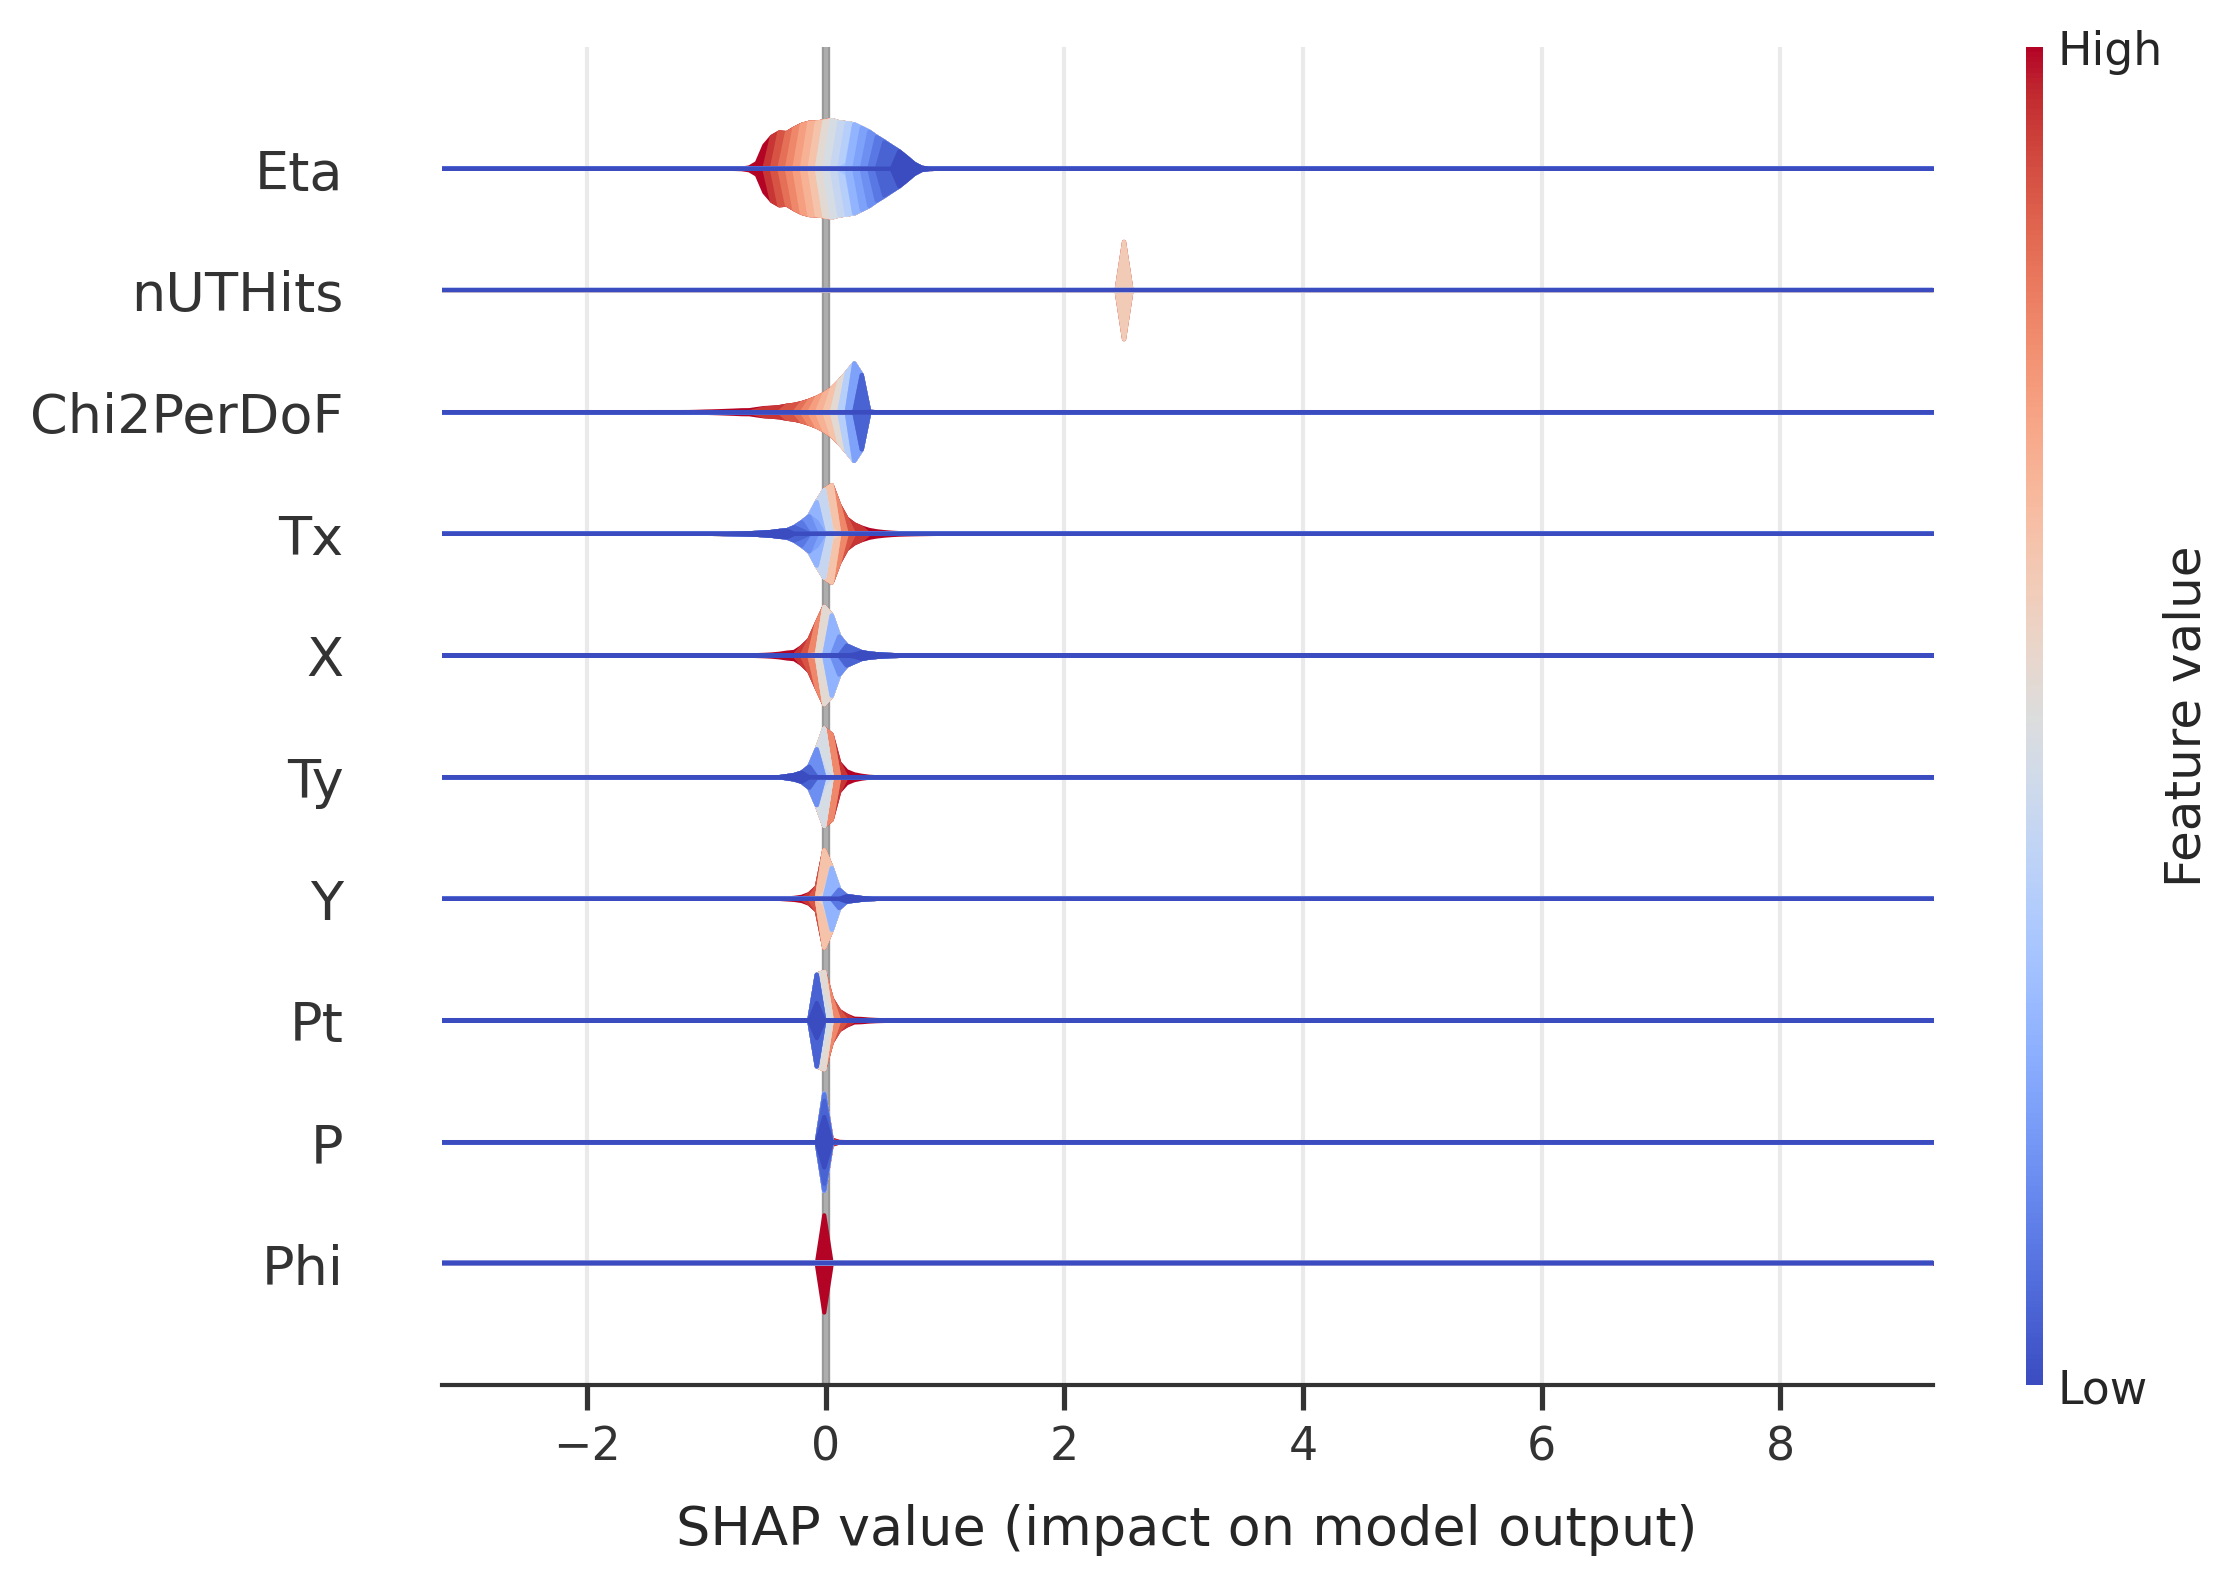

In [12]:
#Shap Evaluation
explainer = shap.LinearExplainer(model,masker=x_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type='layered_violin',show=False)
plt.savefig(f"{figure_directory}/Downstream_Logit_SHAP.png")

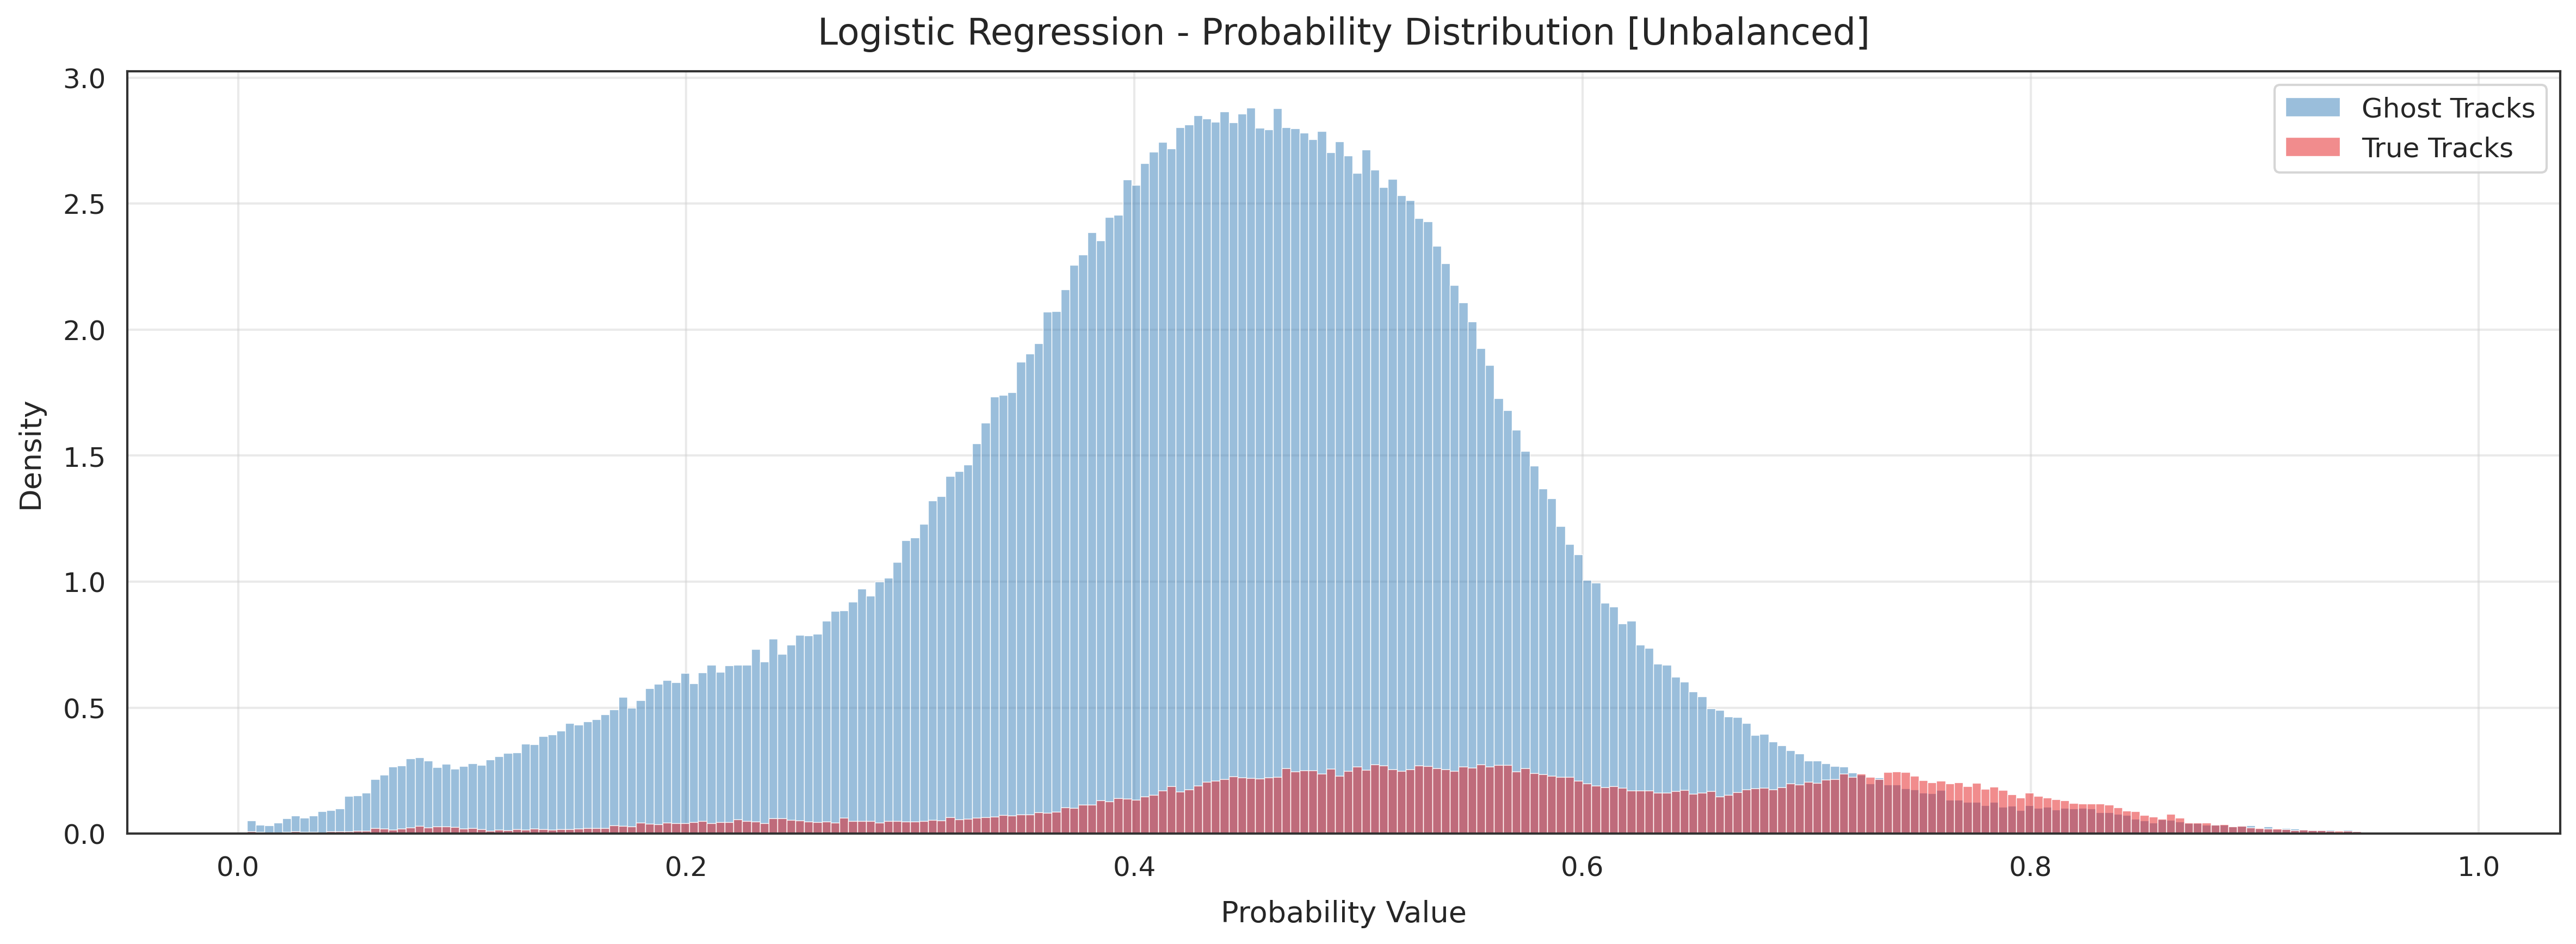

In [13]:
evaluation=x_test.copy()

probabilityValue = model.predict_proba(evaluation)[:,0] #Keeping the first set of probability for the distribution analysis
evaluation['ProbabilityValues']=probabilityValue
evaluation['TrueLabels']=y_test.values

plt.figure(figsize=(16, 6))
plt.title('Logistic Regression - Probability Distribution [Unbalanced]')
sns.histplot( x=evaluation['ProbabilityValues'], hue=evaluation['TrueLabels'], stat='density', bins=250, palette='Set1')
plt.xlabel('Probability Value')
plt.legend(labels=['Ghost Tracks', 'True Tracks'])
plt.savefig(f"{figure_directory}/Downstream_Logit_ProbDist_Unbalanced.png")
plt.tight_layout()
plt.show()

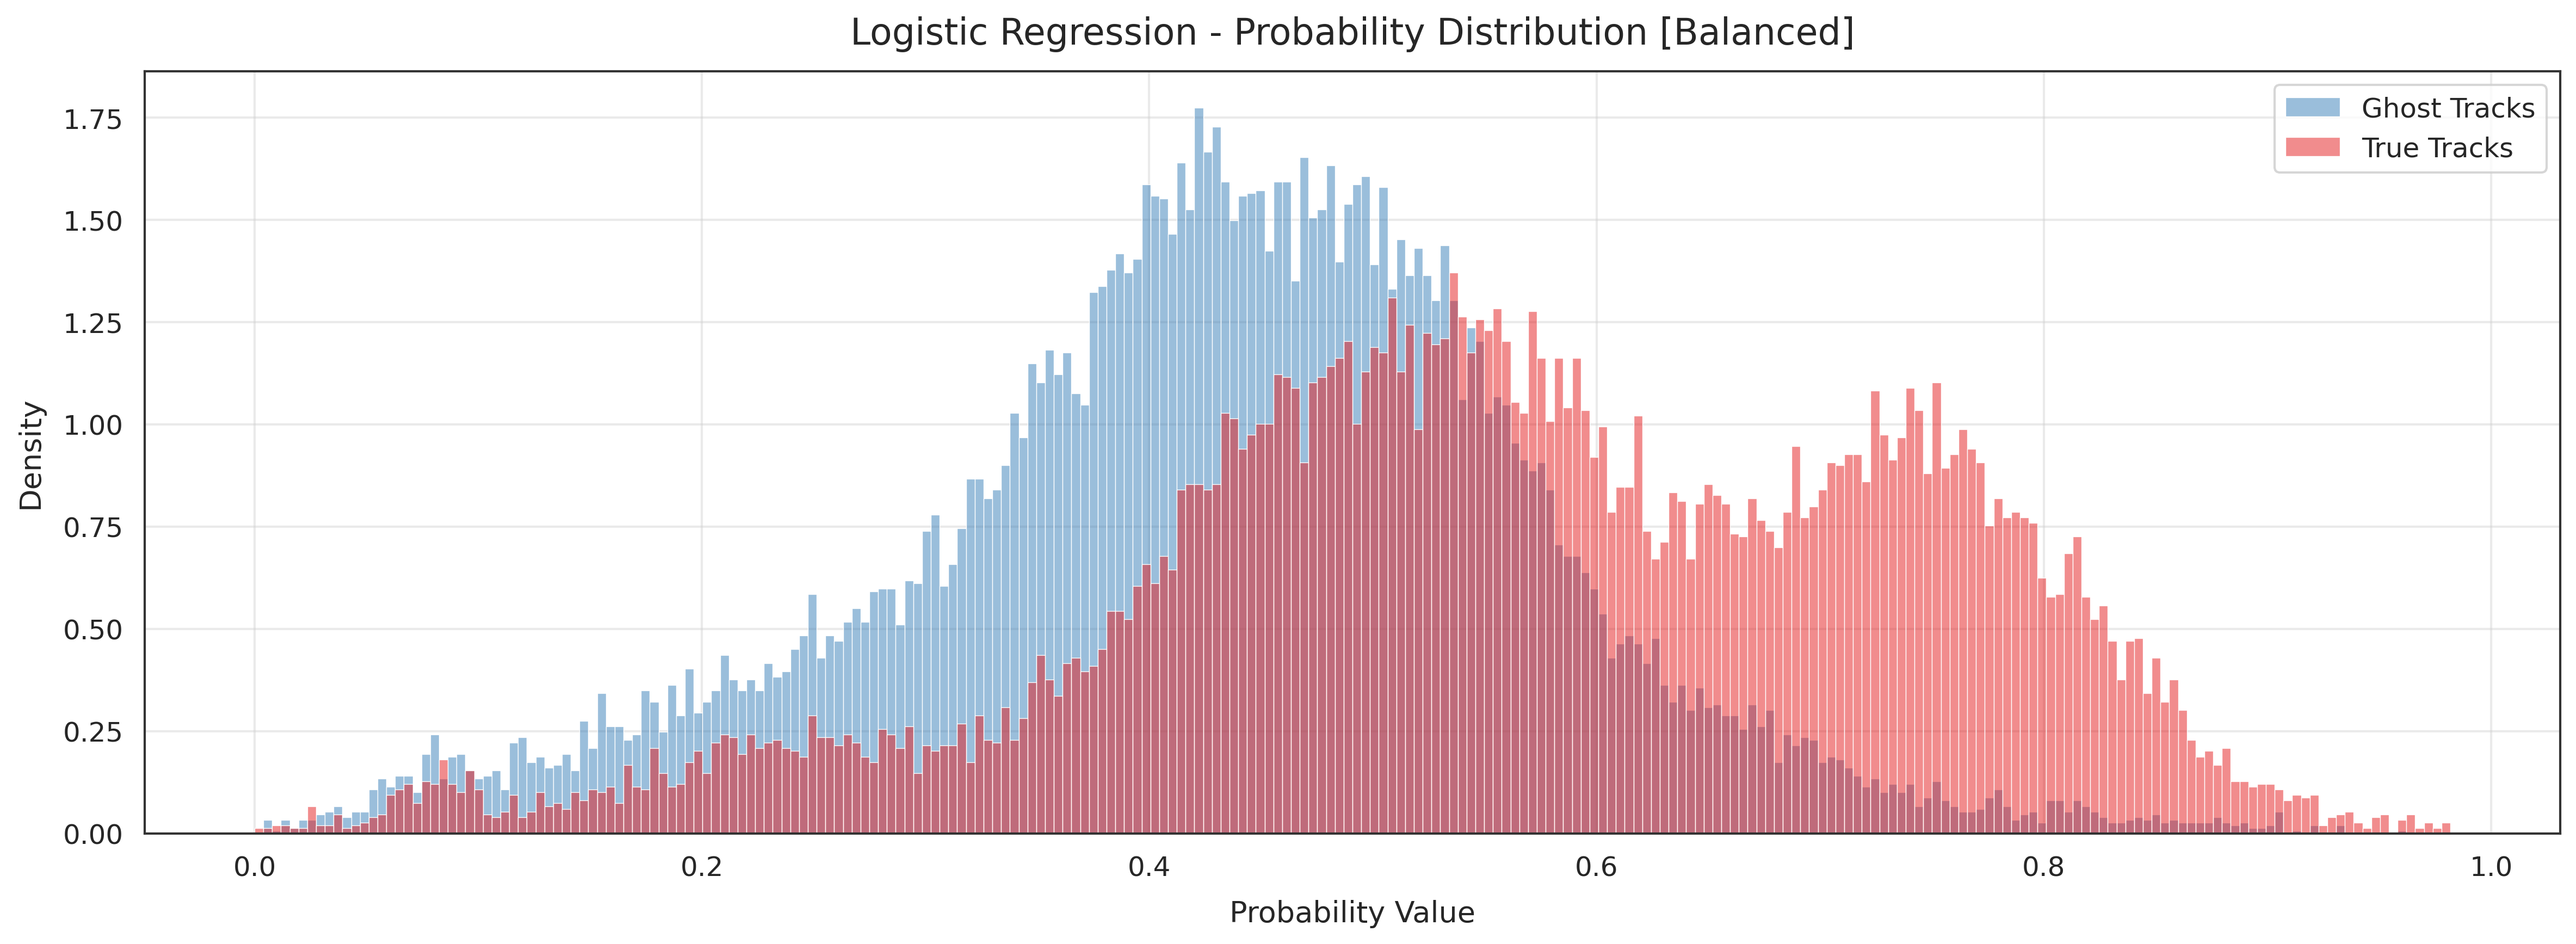

In [14]:
evaluation=x_eval.copy()

probabilityValue = model.predict_proba(evaluation)[:,0] #Keeping the first set of probability for the distribution analysis
evaluation['ProbabilityValues']=probabilityValue
evaluation['TrueLabels']=y_eval.values

plt.figure(figsize=(16, 6))
plt.title('Logistic Regression - Probability Distribution [Balanced]')
sns.histplot( x=evaluation['ProbabilityValues'], hue=evaluation['TrueLabels'], stat='density', bins=250, palette='Set1')
plt.xlabel('Probability Value')
plt.legend(labels=['Ghost Tracks', 'True Tracks'])
plt.savefig(f"{figure_directory}/Downstream_Logit_ProbDist_Balanced.png")
plt.tight_layout()
plt.show()

In [15]:
# Manual Calculations.

In [16]:
#Co-Efficients and Y Intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Coefficients: [[ 2.19257912e+01  4.61242191e+01  2.35069197e+00  7.87147029e-01
  -1.49118862e+00 -7.54540214e-01 -2.18688841e+00 -2.12104297e-02
   6.34736864e+00 -3.58245739e+00]]
Intercept: [-0.48128922]


In [17]:
# Picking a True Track and a Ghost Track.
data_scaled=pd.DataFrame(scaler.fit_transform(data),columns=data.columns)
data_true=data[data['isMatched']==1].iloc[0:1]
data_true_processed=data_scaled[data_scaled['isMatched']==1].iloc[0:1]

data_ghost=data[data['isMatched']==0].iloc[2:3]
data_ghost_processed=data_scaled[data_scaled['isMatched']==0].iloc[2:3]

In [18]:
# Reading and Displaying Picked Tracks, Actual Data and Processed Data

display("TrueTracks:",data_true)
print("---")
display("TrueTracksProcessed:",data_true_processed)
print("---")
display("GhostTracks:",data_ghost)
print("---")
display("GhostTracksProcessed:",data_ghost_processed)
print("---")

'TrueTracks:'

,p,pt,tx,ty,ovtx_x,ovtx_y,eta,phi,nUTHits,chi2perdof,isMatched
0,5909.817556,428.277705,-0.0693,0.02184,-154.245087,51.721882,3.31643,2.8363,4,0.294202,True


---


'TrueTracksProcessed:'

,p,pt,tx,ty,ovtx_x,ovtx_y,eta,phi,nUTHits,chi2perdof,isMatched
0,0.000465,0.001536,0.413622,0.54088,0.399843,0.544891,0.348424,0.951417,0.2,0.05862,1.0


---


'GhostTracks:'

,p,pt,tx,ty,ovtx_x,ovtx_y,eta,phi,nUTHits,chi2perdof,isMatched
11,25600.351052,1226.189668,-0.037552,0.029821,-89.676453,67.22641,3.731268,2.470446,4,0.276966,False


---


'GhostTracksProcessed:'

,p,pt,tx,ty,ovtx_x,ovtx_y,eta,phi,nUTHits,chi2perdof,isMatched
11,0.002486,0.004434,0.452196,0.555885,0.441706,0.557466,0.431513,0.893189,0.2,0.055171,0.0


---


In [19]:
# Building Manual Calculation Table.
desc_=pd.DataFrame(columns,columns=['Features'])
desc_['TrueTrack']=data_true.drop(['isMatched'],axis=1).values[0]
desc_['TrueTrackProcessed']=data_true_processed.drop(['isMatched'],axis=1).values[0]
desc_['GhostTrack']=data_ghost.drop(['isMatched'],axis=1).values[0]
desc_['GhostTrackProcessed']=data_ghost_processed.drop(['isMatched'],axis=1).values[0]
desc_['Co-Effs']=model.coef_[0]

desc_['True-Eff']=desc_['TrueTrackProcessed']*desc_['Co-Effs']
desc_['Ghost-Eff']=desc_['GhostTrackProcessed']*desc_['Co-Effs']
desc_

,Features,TrueTrack,TrueTrackProcessed,GhostTrack,GhostTrackProcessed,Co-Effs,True-Eff,Ghost-Eff
0,P,5909.817556,0.000465,25600.351052,0.002486,21.925791,0.010205,0.054513
1,Pt,428.277705,0.001536,1226.189668,0.004434,46.124219,0.070869,0.204500
2,Tx,-0.069300,0.413622,-0.037552,0.452196,2.350692,0.972297,1.062972
3,Ty,0.021840,0.540880,0.029821,0.555885,0.787147,0.425752,0.437564
4,X,-154.245087,0.399843,-89.676453,0.441706,-1.491189,-0.596242,-0.658666
5,Y,51.721882,0.544891,67.226410,0.557466,-0.754540,-0.411142,-0.420631
6,Eta,3.316430,0.348424,3.731268,0.431513,-2.186888,-0.761964,-0.943671
7,Phi,2.836300,0.951417,2.470446,0.893189,-0.021210,-0.020180,-0.018945
8,nUTHits,4.000000,0.200000,4.000000,0.200000,6.347369,1.269474,1.269474
9,Chi2PerDoF,0.294202,0.058620,0.276966,0.055171,-3.582457,-0.210002,-0.197647


In [20]:
# Following the Equation Y = MX + C

y_ValTrue=desc_['True-Eff'].sum()+model.intercept_[0]

y_ValGhost=desc_['Ghost-Eff'].sum()+model.intercept_[0]

In [21]:
# Y Value and the Logit Value (Probability - True Tracks)
print("Y- Value :",y_ValTrue)
logit(y_ValTrue)

Y- Value : 0.2677768601421462
Probability Value: 0.5665470461776676


In [22]:
# Y Value and the Logit Value (Probability - Ghost Tracks)
print("Y- Value :",y_ValGhost)
logit(y_ValGhost)

Y- Value : 0.30817234257242687
Probability Value: 0.5764390881137882


In [23]:
#End of Notebook